# **Data Cleaning**

## Objectives

* Prepare the dataset for ML by:
  * Assessing and handling missing data.
  * Removing irrelevant or problematic features.
  * Ensuring consistency in data types.
  * Saving clean datasets for training and testing.

## Inputs

* `outputs/datasets/collection/house_prices_records.csv`: raw dataset containing house records.

## Outputs

* `outputs/datasets/cleaned/TrainSetCleaned.csv`: cleaned training dataset.
* `outputs/datasets/cleaned/TestSetCleaned.csv`: cleaned test dataset.

## Additional Comments

* This notebook focuses solely on the cleaned house records (`df_main`).  
* `inherited_houses.csv` is kept separate and will be used later for prediction once the model is trained.  

---

# Change Working Directory

In [2]:
import os 

project_root = "/workspaces/milestone-project-heritage-housing-issues"
os.chdir(project_root)

print("Current working directory set to:")
print(os.getcwd())

Current working directory set to:
/workspaces/milestone-project-heritage-housing-issues


---

# Load Collected data

In [13]:
import pandas as pd

# Load the dataset prepared during EDA
file_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(file_path)
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

In [14]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute / len(df) * 100, 2)

    df_missing_data = (
        pd.DataFrame({
            "RowsWithMissingData": missing_data_absolute,
            "PercentageOfDataset": missing_data_percentage,
            "DataType": df.dtypes
        })
        .sort_values(by='PercentageOfDataset', ascending=False)
        .query("PercentageOfDataset > 0")
    )

    return df_missing_data

EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,235,16.10,object
BsmtFinType1,145,9.93,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
BsmtExposure,38,2.60,object
MasVnrArea,8,0.55,float64


# Missing Data Profiling

In [15]:
from ydata_profiling import ProfileReport

vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("✅ There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation and PPS Analysis

/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt

*** Spearman Correlation ***


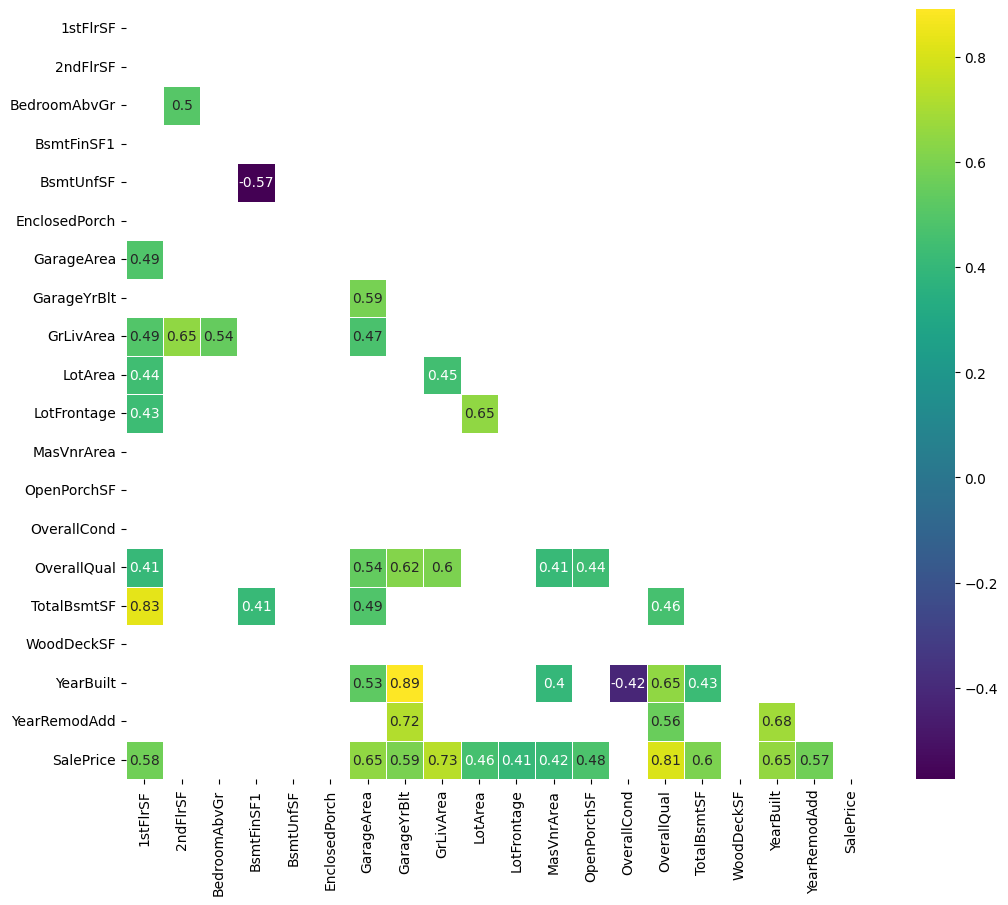

*** Pearson Correlation ***


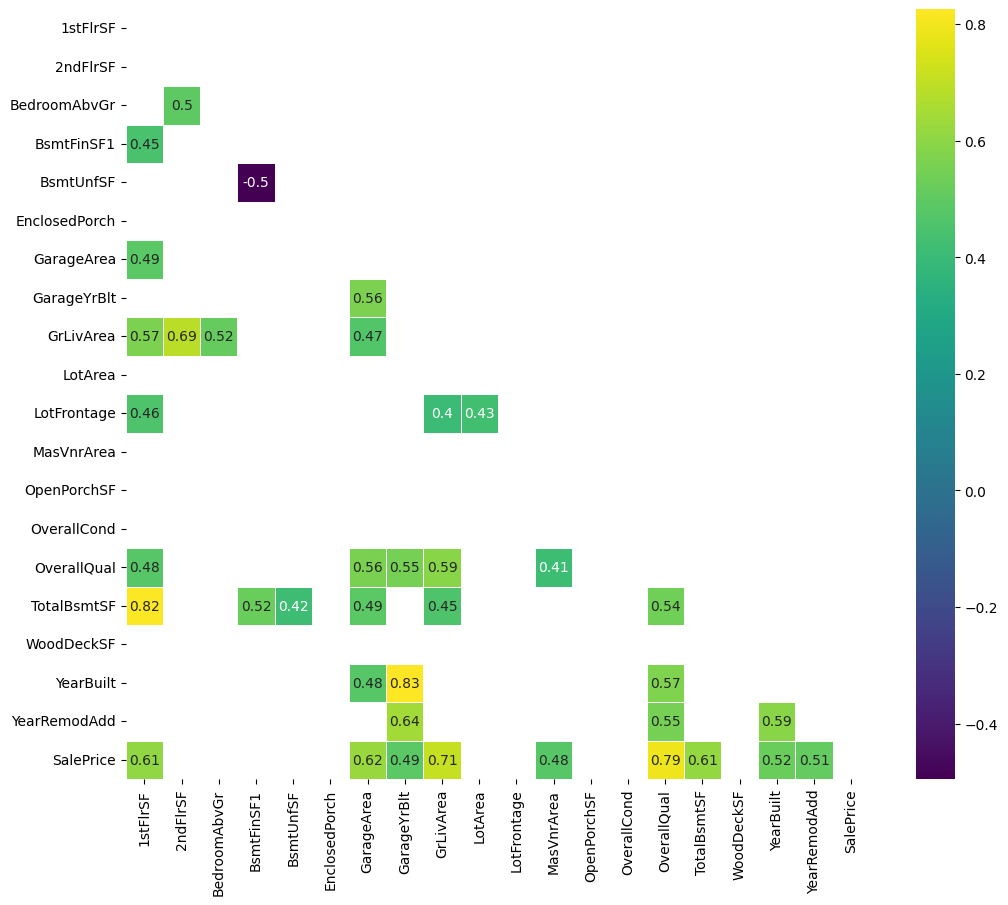

*** Power Predictive Score (PPS) ***


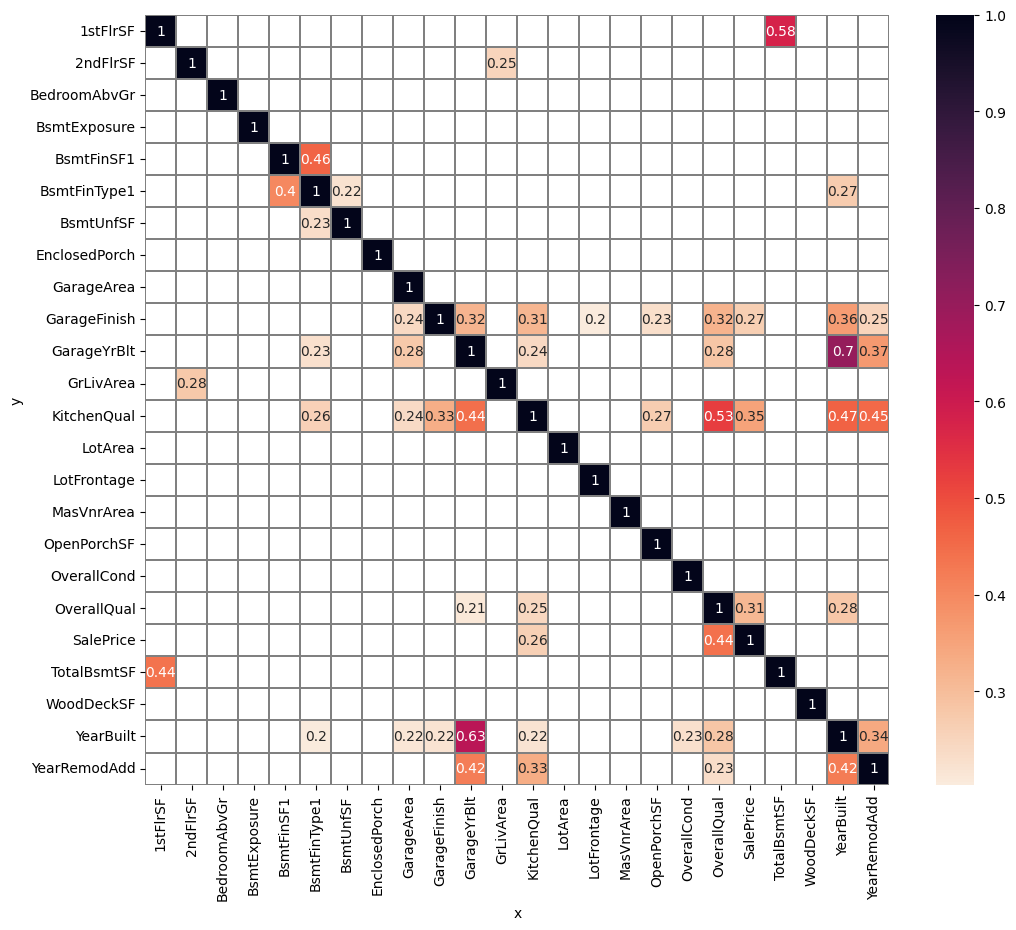

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
%matplotlib inline

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, mask=mask, cmap='viridis',
                    annot_kws={"size": font_annot}, ax=ax, linewidth=0.5)
        ax.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()

def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, mask=mask, cmap='rocket_r',
                    annot_kws={"size": font_annot}, ax=ax, linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()

def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

    return df_corr_pearson, df_corr_spearman, pps_matrix

def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold):
    print("*** Spearman Correlation ***")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=(12, 10), font_annot=10)

    print("*** Pearson Correlation ***")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=(12, 10), font_annot=10)

    print("*** Power Predictive Score (PPS) ***")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=(12, 10), font_annot=10)

df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)
DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold=0.4, PPS_Threshold=0.2)

In [17]:
def get_low_corr_features(df_corr, target_col, threshold):
    # Get absolute correlation of all features with target_col
    corr_with_target = df_corr[target_col].abs()
    # Filter features below threshold, exclude the target itself
    low_corr_features = corr_with_target[(corr_with_target < threshold) & (corr_with_target.index != target_col)].index.tolist()
    return low_corr_features

def get_low_pps_features(pps_matrix, target_col, threshold):
    # PPS matrix index = y (predicted), columns = x (predictor)
    # We want PPS of each feature predicting target_col
    if target_col not in pps_matrix.index or target_col not in pps_matrix.columns:
        return []
    pps_with_target = pps_matrix.loc[target_col].drop(target_col)  # drop self PPS = 1
    low_pps_features = pps_with_target[pps_with_target < threshold].index.tolist()
    return low_pps_features


# Calculate correlations and PPS
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

# Set thresholds
corr_threshold = 0.3
pps_threshold = 0.15
target = 'SalePrice'

# Get low correlation features (pearson and spearman)
low_corr_pearson = get_low_corr_features(df_corr_pearson, target, corr_threshold)
low_corr_spearman = get_low_corr_features(df_corr_spearman, target, corr_threshold)

# Get low PPS features
low_pps = get_low_pps_features(pps_matrix, target, pps_threshold)

print(f"Features with Pearson correlation < {corr_threshold} with {target}:\n{low_corr_pearson}\n")
print(f"Features with Spearman correlation < {corr_threshold} with {target}:\n{low_corr_spearman}\n")
print(f"Features with PPS < {pps_threshold} predicting {target}:\n{low_pps}\n")


/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt

Features with Pearson correlation < 0.3 with SalePrice:
['BedroomAbvGr', 'BsmtUnfSF', 'EnclosedPorch', 'LotArea', 'OverallCond', 'WoodDeckSF']

Features with Spearman correlation < 0.3 with SalePrice:
['2ndFlrSF', 'BedroomAbvGr', 'BsmtUnfSF', 'EnclosedPorch', 'OverallCond', 'WoodDeckSF']

Features with PPS < 0.15 predicting SalePrice:
['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'TotalBsmtSF', 'WoodDeckSF', 'YearRemodAdd']



/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/home/cistudent/.local/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dt

# Data Cleaning

Strategy to Drop Variables
We drop columns if:
* More than 80% missing values
* Duplicated or irrelevant (e.g., unique IDs)

In [18]:
from feature_engine.selection import DropFeatures

# Dropping columns with excessive missing data or many zeros
features_to_drop = ['EnclosedPorch', 'WoodDeckSF']

print(f"* {len(features_to_drop)} variables to drop \n\n{features_to_drop}")

dropper = DropFeatures(features_to_drop=features_to_drop)
df = dropper.fit_transform(df)

* 2 variables to drop 

['EnclosedPorch', 'WoodDeckSF']


# Impute Missing Values

In [27]:
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,3.0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.0,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


In [29]:
from sklearn.impute import SimpleImputer
df = pd.read_csv('outputs/datasets/collection/house_prices_records.csv')

categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Fill categorical with mode
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Fill numerical with median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Re-check for any remaining missing data
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType


In [30]:
print(df.isnull().values.any())


False


In [36]:
import os
try:
    os.makedirs("outputs/datasets/cleaned", exist_ok=True)
except Exception as e:
    print(e)

df.to_csv("outputs/datasets/cleaned/house_prices_cleaned.csv", index=False)
print("✅ Cleaned dataset saved!")

✅ Cleaned dataset saved!


# SPlit Train and Test Set

In [33]:
from sklearn.model_selection import train_test_split

TrainSet, TestSet = train_test_split(df, test_size=0.2, random_state=42)

print(f"✅ TrainSet shape: {TrainSet.shape}")
print(f"✅ TestSet shape: {TestSet.shape}")

EvaluateMissingData(TrainSet)

✅ TrainSet shape: (1168, 24)
✅ TestSet shape: (292, 24)


,RowsWithMissingData,PercentageOfDataset,DataType


---

# Save Cleaned Data

In [34]:
import os
try:
    os.makedirs("outputs/datasets/cleaned", exist_ok=True)
except Exception as e:
    print(e)

TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)
print("✅ Files saved.")


✅ Files saved.


---

# Data Cleaning Summary

* Imputed all missing numerical values using median.
* Imputed categorical columns with mode (the most frequent value).
* Verified no remaining missing data.
* Split dataset into 80% training and 20% testing sets.
* Saved TrainSetCleaned and TestSetCleaned